In [ ]:
from datasets import Dataset
import pandas as pd
import re
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import TextClassificationPipeline
    
import matplotlib.pyplot as plt

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text) # remove html tags like <br /> etc
    text = re.sub(r"http\S+|www\S+", "", text) # remove URLs
    text = re.sub(r"[^a-z\s]", "", text) # remove punctuation (!?- etc) and numbers
    text = re.sub(r"\s+", " ", text).strip() # remove unnecesary whitespaces (fe "  ")
    return text

def evaluate_model(preds_output, y_test, label_names=None, title="Confusion Matrix"):
    y_pred = np.argmax(preds_output.predictions, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_names))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()

def tokenize(example):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)

In [5]:
df = pd.read_csv("../data/IMDB Dataset.csv")

df["review"] = df["review"].apply(clean_text)

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["sentiment"])  # positive=1, negative=0


X_train, X_test, y_train, y_test = train_test_split(
    df["review"], df["label"], test_size=0.2, stratify=df["label"]
)

In [6]:
train_dataset = Dataset.from_pandas(pd.DataFrame({"text": X_train, "label": y_train}))
test_dataset = Dataset.from_pandas(pd.DataFrame({"text": X_test, "label": y_test}))

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map: 100%|██████████| 10000/10000 [00:29<00:00, 344.40 examples/s]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Używane urządzenie: GPU


Epoch,Training Loss,Validation Loss
1,0.202400,0.213229
2,0.132100,0.252727
3,0.074500,0.298339



Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.94      0.93      5000
    positive       0.93      0.93      0.93      5000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



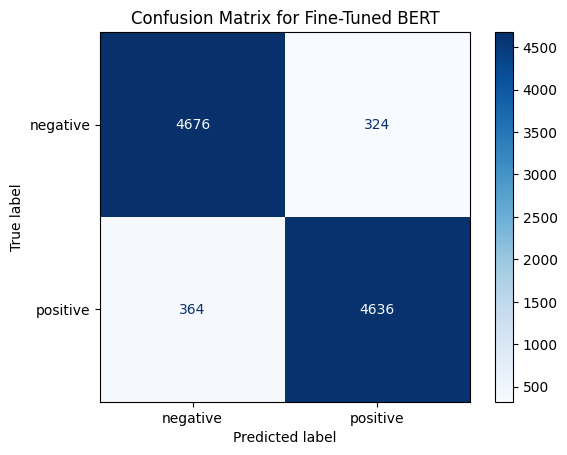

In [7]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Argumenty treningowe
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)
print("Używane urządzenie:", "GPU" if torch.cuda.is_available() else "CPU")

trainer.train()
trainer.evaluate()

preds = trainer.predict(test_dataset)

evaluate_model(
    preds_output=preds,
    y_test=y_test,
    label_names=["negative", "positive"],
    title="Confusion Matrix for Fine-Tuned BERT"
)

In [ ]:
# model = BertForSequenceClassification.from_pretrained("models/imdb_bert")
# tokenizer = BertTokenizer.from_pretrained("models/imdb_bert")

# pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, device=0 if torch.cuda.is_available() else -1)

# text = "This movie was absolutely amazing, I loved it!"

# # Predykcja
# result = pipeline(text)
# print(result)

Device set to use cuda:0


[[{'label': 'LABEL_0', 'score': 0.001673404942266643}, {'label': 'LABEL_1', 'score': 0.9983265995979309}]]


c:\Users\Hubert\Desktop\EDAN\edan_project\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
